# Power Cost Minimization

### Defining Givens

In [1]:
#Given: P_L over a day
#Given: P_ramp

#Minimize: Power cost
    #Sum from t=1 to t=24 C_1^t + C_2^t

#Power Plant Costs:
    #Coal: C_1^t = P_g_1**2 + 4*P_g_1 + 100
    #Gas: C_2^t = 0.9*P_g_1**2 + 5*P_g_2 + 80

#Optimize: P_g_1 and P_g_2 over the gourse of a day

#General Equations
    #P_L^t = P_g_1^t + P_g_2^t
    #P_g_1^t >= 0 for all t
    #P_g_2^t >= 0 for all t
    
#Pramp, gas ≈ 20 [MW/min]
#Pramp, coal ≈ 2 [MW/min]

### Importing 

In [2]:
import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Defining Values

In [3]:
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 07.xlsx')
# print (df)

### Establishing Equations and Solving

#### Simple Version no Ramp

In [4]:
P_L = []
for n in range (0, 24):
    P_L = P_L + [df.at[n, 'P_L']]

P_g_1 = cp.Variable(24)
P_g_2 = cp.Variable(24)

C_1 = P_g_1**2 + 4*P_g_1 + 100
C_2 = 0.9*P_g_2**2 + 5*P_g_2 + 80

objective = sum(C_1 + C_2)

constraints = []

for n in range (0, 24):
    constraints += [P_g_1[n] >= 0] #P_g_1 >= 0
    constraints += [P_g_2[n] >= 0] #P_g_2 >= 0
    constraints += [P_L[n] == P_g_1[n] + P_g_2[n]] #P_L = P_g_1 + P_g_2
    n+1
    
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

print("status:", prob.status)
print("optimal cost: $", prob.value)
# print("optimal power consumption over a day: coal:", P_g_1.value)
# print("optimal power consumption over a day: gas: ", P_g_2.value)

status: optimal
optimal cost: $ 15488405.263157897


#### Including Ramp

#### Scenario 1: P_ramp_g ≈ 20 [MW/min], P_ramp_c ≈ 2 [MW/min]

In [5]:
P_ramp_g = 1200 #[MW/hr]
P_ramp_c = 120 #[MW/hr]

P_L = []
for n in range (0, 24):
    P_L = P_L + [df.at[n, 'P_L']]

P_g_1 = cp.Variable(24)
P_g_2 = cp.Variable(24)

C_1 = P_g_1**2 + 4*P_g_1 + 100
C_2 = 0.9*P_g_2**2 + 5*P_g_2 + 80

objective = sum(C_1 + C_2)

constraints = []

for n in range (0, 24):
    constraints += [P_g_1[n] >= 0] #P_g_1 >= 0
    constraints += [P_g_2[n] >= 0] #P_g_2 >= 0
    constraints += [P_L[n] == P_g_1[n] + P_g_2[n]] #P_L = P_g_1 + P_g_2
    n+1
    
for n in range (0, 23): 
    a = P_g_1[n]
    b = P_g_1[n+1]
    c = P_g_2[n]
    d = P_g_2[n+1]
    constraints += [(a - b) <= P_ramp_c, (a - b) >= -P_ramp_c] 
    constraints += [(c - d) <= P_ramp_g, (c - d) >= -P_ramp_g] 
    n+1
    
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

print("status:", prob.status)
print("optimal value", prob.value)
# print("optimal var", P_g_1.value, P_g_2.value)

status: optimal
optimal value 15488441.192105265


#### Scenario 2: P_ramp_g ≈ 25 [MW/min], P_ramp_c ≈ 2 [MW/min]

In [6]:
P_ramp_g = 1500 #[MW/hr]
P_ramp_c = 120 #[MW/hr]

h = 24 # number of hours 

P_L = []
for n in range (0, h):
    P_L = P_L + [df.at[n, 'P_L']]

P_g_1 = cp.Variable(h)
P_g_2 = cp.Variable(h)

C_1 = P_g_1**2 + 4*P_g_1 + 100
C_2 = 0.9*P_g_2**2 + 5*P_g_2 + 80

objective = sum(C_1 + C_2)

constraints = []

for n in range (0, h):
    constraints += [P_g_1[n] >= 0] #P_g_1 >= 0
    constraints += [P_g_2[n] >= 0] #P_g_2 >= 0
    constraints += [P_L[n] == P_g_1[n] + P_g_2[n]] #P_L = P_g_1 + P_g_2
    n+1
    
for n in range (0, h-1): 
    a = P_g_1[n]
    b = P_g_1[n+1]
    c = P_g_2[n]
    d = P_g_2[n+1]
    constraints += [(a - b) <= P_ramp_c, (a - b) >= -P_ramp_c]
    constraints += [(c - d) <= P_ramp_g, (c - d) >= -P_ramp_g] 
    n+1
    
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

print("status:", prob.status)
print("Minimized Cost: $", prob.value)
#print("optimal var", P_g_1.value, P_g_2.value)

status: optimal
Minimized Cost: $ 15488441.192105265


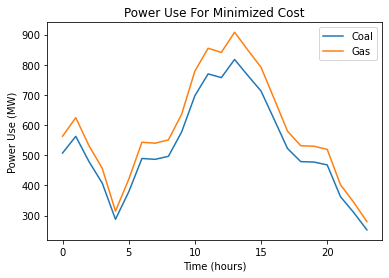

In [7]:
t = []

for n in range (0, h):
    t = t + [n+1]
    n+1

plt.plot(range(0,24), P_g_1.value, label = 'Coal') # coal
plt.plot(range(0,24), P_g_2.value, label = 'Gas'); # gas
plt.xlabel("Time (hours)")
plt.ylabel("Power Use (MW)")
plt.title("Power Use For Minimized Cost")
leg = plt.legend()

#### Scenario 3: Assume all Power Supplied by Coal (Ignore Ramp)

In [8]:
P_g_1 = []
C_1 = []

for n in range (0, 24):
    P_g_1 = P_g_1 + [df.at[n, 'P_L']]
    C_1 = C_1 + [P_g_1[n]**2 + 4*P_g_1[n] + 100]

cost = sum(C_1)

print("cost: $", cost)

cost: $ 32542420.0


#### Scenario 4: Assume all Power Supplied by Gas (Ignore Ramp)

In [9]:
P_g_2 = []
C_2 = []

for n in range (0, 24):
    P_g_2 = P_g_2 + [df.at[n, 'P_L']]
    C_2 = C_2 + [0.9*P_g_2[n]**2 + 5*P_g_2[n] + 80]

cost = sum(C_2)

print("cost: $", cost)

cost: $ 29325388.0
